# Malaria Cell Classification - Full Jupyter Notebook
Including:
1. Data Loading and Preprocessing
2. CNN and MobileNetV2 Training
3. Confusion Matrix + Classification Report
4. TFLite Export

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2


In [ ]:

DATA_DIR = '../dataset/cell_images/'
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

## Step 1: Data Generators

In [ ]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


## Step 2: Build MobileNetV2 Model

In [ ]:

base_model = MobileNetV2(input_shape=(*IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

9406464/9406464 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                           

## Step 3: Train Head

In [ ]:

initial_epochs = 5
history = model.fit(
    train_generator,
    epochs=initial_epochs,
    validation_data=val_generator
)

Epoch 1/5
689/689 [==============================] - 589s 850ms/step - loss: 0.2812 - accuracy: 0.8875 - val_loss: 0.2317 - val_accuracy: 0.9073
Epoch 2/5
689/689 [==============================] - 512s 743ms/step - loss: 0.2317 - accuracy: 0.9102 - val_loss: 0.2195 - val_accuracy: 0.9165
Epoch 3/5
689/689 [==============================] - 416s 603ms/step - loss: 0.2232 - accuracy: 0.9149 - val_loss: 0.2229 - val_accuracy: 0.9171
Epoch 4/5
689/689 [==============================] - 389s 564ms/step - loss: 0.2184 - accuracy: 0.9181 - val_loss: 0.2110 - val_accuracy: 0.9176
Epoch 5/5
689/689 [==============================] - 383s 556ms/step - loss: 0.2133 - accuracy: 0.9202 - val_loss: 0.2038 - val_accuracy: 0.9249


## Step 4: Fine-tune Base

In [ ]:

base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_generator
)


Epoch 5/15
689/689 [==============================] - 1335s 2s/step - loss: 0.2569 - accuracy: 0.9079 - val_loss: 1.7151 - val_accuracy: 0.5969
Epoch 6/15
689/689 [==============================] - 1302s 2s/step - loss: 0.1788 - accuracy: 0.9390 - val_loss: 0.6318 - val_accuracy: 0.8125
Epoch 7/15
689/689 [==============================] - 1178s 2s/step - loss: 0.1537 - accuracy: 0.9478 - val_loss: 0.2495 - val_accuracy: 0.9245
Epoch 8/15
689/689 [==============================] - 1181s 2s/step - loss: 0.1431 - accuracy: 0.9512 - val_loss: 0.1713 - val_accuracy: 0.9414
Epoch 9/15
689/689 [==============================] - 1321s 2s/step - loss: 0.1308 - accuracy: 0.9564 - val_loss: 0.1508 - val_accuracy: 0.9483
Epoch 10/15
689/689 [==============================] - 1271s 2s/step - loss: 0.1271 - accuracy: 0.9582 - val_loss: 0.1503 - val_accuracy: 0.9514
Epoch 11/15
689/689 [==============================] - 1213s 2s/step - loss: 0.1196 - accuracy: 0.9603 - val_loss: 0.1534 - val_accurac

## Step 5: Save Model

In [ ]:

model.save('../models/malaria_mobilenetv2_model.h5')


c:\Users\zelalem.wubet\projects\personal\undp\malaria-diagnosis-system\model_training\venv310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Step 6: Load Test Data

In [ ]:

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 27558 images belonging to 2 classes.


## Step 7: Evaluate on Test Set

862/862 [==============================] - 301s 347ms/step
              precision    recall  f1-score   support

 Parasitized       0.99      0.94      0.96     13779
  Uninfected       0.94      0.99      0.96     13779

    accuracy                           0.96     27558
   macro avg       0.97      0.96      0.96     27558
weighted avg       0.97      0.96      0.96     27558



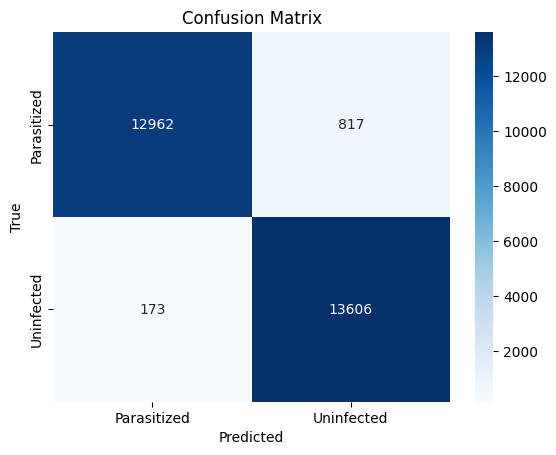

In [ ]:

Y_pred = model.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int).ravel()
y_true = test_generator.classes

print(classification_report(y_true, y_pred, target_names=['Parasitized', 'Uninfected']))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Parasitized', 'Uninfected'], yticklabels=['Parasitized', 'Uninfected'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Step 8: Convert to TFLite

In [ ]:

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('../models/malaria_mobilenetv2_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ZELALE~1.WUB\AppData\Local\Temp\tmpl4mtjq9t\assets


INFO:tensorflow:Assets written to: C:\Users\ZELALE~1.WUB\AppData\Local\Temp\tmpl4mtjq9t\assets
